In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pickle
import random
from torch.utils.data import TensorDataset, DataLoader
import time 

random_seed = 42
torch.manual_seed(random_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

np.random.seed(random_seed)
random.seed(random_seed)

torch.cuda.manual_seed(random_seed)
torch.cuda.manual_seed_all(random_seed) 

In [2]:
doGPU=False
if (doGPU):
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [3]:
with open('faces_python.pkl', 'rb') as f:
    face_data = pickle.load(f).astype(np.float32)
with open('nonfaces_python.pkl', 'rb') as f:
    nonface_data = pickle.load(f).astype(np.float32)

In [4]:
print("face_data shape:", face_data.shape)
print("nonface_data shape:", nonface_data.shape)

face_data shape: (13233, 1024)
nonface_data shape: (50000, 1024)


In [5]:
# Normalize data
print("face_data min, max:", face_data.min(), face_data.max())
print("nonface_data min, max:", nonface_data.min(), nonface_data.max())

# [0.0, 255.0] -> [0, 1]
nonface_data /= 255.

# [0, 1] -> [-1, 1]
face_data -= 0.5
face_data *= 2

nonface_data -= 0.5
nonface_data *= 2

print("face_data min, max:", face_data.min(), face_data.max())
print("nonface_data min, max:", nonface_data.min(), nonface_data.max())

face_data min, max: 0.0 1.0
nonface_data min, max: 0.0 255.0
face_data min, max: -1.0 1.0
nonface_data min, max: -1.0 1.0


In [6]:
# train-test split
train_test_split = 0.8

# prepare faces
tmp1 = np.round(face_data.shape[0]*train_test_split).astype(int)
train_ct1 = np.ones(tmp1) 
test_ct1 = np.ones((face_data.shape[0]-tmp1,1))
train_ci1 = face_data[:tmp1,:] 
test_ci1 = face_data[tmp1:,:]

# prepare non-faces
# note that CIFAR has a lot more images, so here we 
# restrict also this dataset to the same number of images
# as the face dataset!
tmp2 = np.round(face_data.shape[0]*train_test_split).astype(int)
train_ct2 = np.zeros(tmp2) 
test_ct2 = np.zeros((face_data.shape[0]-tmp2,1))
train_ci2 = nonface_data[:tmp2,:] 
test_ci2 = nonface_data[tmp2:face_data.shape[0],:]

# now concatenate arrays
train_ct12 = np.concatenate((train_ct1,train_ct2),axis=0)
train_ci12 = np.concatenate((train_ci1,train_ci2),axis=0).reshape(-1,1,32,32)

test_ct12 = np.concatenate((test_ct1,test_ct2),axis=0)
test_ci12 = np.concatenate((test_ci1,test_ci2),axis=0).reshape(-1,1,32,32)

#
train_ct12 = torch.tensor(train_ct12, dtype=torch.long)
train_ci12 = torch.tensor(train_ci12, dtype=torch.float32)
test_ct12 = torch.tensor(test_ct12, dtype=torch.long)
test_ci12 = torch.tensor(test_ci12, dtype=torch.float32)


In [7]:
# make dataset and dataloader
trainset = TensorDataset(train_ci12, train_ct12)
testset = TensorDataset(test_ci12, test_ct12)

train_loader = DataLoader(trainset, batch_size=16, shuffle=True)
test_loader = DataLoader(testset, batch_size=16, shuffle=True)

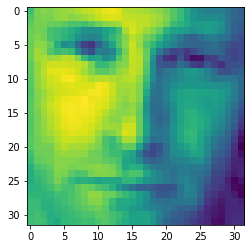

In [9]:
import matplotlib.pyplot as plt
plt.imshow(face_data[0].reshape(32,32))
plt.show()

In [10]:
# defines a small CNN based on the nn.Module class
class CNN(nn.Module):
    # every nn needs the constructor
    def __init__(self, num_layer, size, increase):
        # call the pytorch constructor of the parent class
        super().__init__()
        self.num_layer = num_layer
        self.size = size
        self.increase = increase
        self.padd = int(self.size/2)
        # first convolutional layer
        # 3 input layers [because of color images]
        # 16 filters with 5x5 pixels each
        self.conv1 = nn.Conv2d(1, 8, self.size, padding=self.padd)
        self.conv2 = nn.Conv2d(8, 16, self.size, padding=self.padd)
        self.conv3 = nn.Conv2d(16, 32, self.size,padding=self.padd)
        self.conv4 = nn.Conv2d(32, 64, self.size, padding=self.padd)

        self.conv5 = nn.Conv2d(1, 16, self.size, padding=self.padd)
        self.conv6 = nn.Conv2d(16, 16, self.size, padding=self.padd)

        # pool using 2x2 grid [downsampling]
        self.pool = nn.MaxPool2d(2, 2)

        # fully connected layer 
        self.fc1 = nn.Linear(2 ** (self.num_layer+2) * int(32/(2*self.num_layer)) * int(32/(2*self.num_layer)), 2)
        
        self.fc2 = nn.Linear(16 * int(32/(2*self.num_layer)) * int(32/(2*self.num_layer)), 2)
    # every nn needs a forward pass function which takes data x
    # as input and returns x as output
    # the forward function uses the layers defined in the 
    # constructor to make the network architecture
    def forward(self, x):
        if self.increase == True:
            if self.num_layer == 2:
                # Relu of first CONV and pool
                x = self.pool(F.relu(self.conv1(x)))
                # Relu of second CONV and pool
                x = self.pool(F.relu(self.conv2(x)))
                # flatten output so that it fits into fc layer
                x = torch.flatten(x, 1) # flatten all dimensions except batch
                x = self.fc1(x)

            elif self.num_layer == 3:
                x = self.pool(F.relu(self.conv1(x)))
                x = self.pool(F.relu(self.conv2(x)))
                x = self.pool(F.relu(self.conv3(x)))
                x = torch.flatten(x, 1)
                x = self.fc1(x)

            elif self.num_layer == 4:
                x = self.pool(F.relu(self.conv1(x)))
                x = self.pool(F.relu(self.conv2(x)))
                x = self.pool(F.relu(self.conv3(x)))
                x = self.pool(F.relu(self.conv4(x)))
                x = torch.flatten(x, 1)
                x = self.fc1(x)
            else:
                print('Error')
        else :
            if self.num_layer == 2:
                x = self.pool(F.relu(self.conv5(x)))
                x = self.pool(F.relu(self.conv6(x)))
                x = torch.flatten(x, 1) 
                x = self.fc2(x)

            elif self.num_layer == 3:
                x = self.pool(F.relu(self.conv5(x)))
                x = self.pool(F.relu(self.conv6(x)))
                x = self.pool(F.relu(self.conv6(x)))
                x = torch.flatten(x, 1)
                x = self.fc2(x)

            elif self.num_layer == 4:
                x = self.pool(F.relu(self.conv5(x)))
                x = self.pool(F.relu(self.conv6(x)))
                x = self.pool(F.relu(self.conv6(x)))
                x = self.pool(F.relu(self.conv6(x)))
                x = torch.flatten(x, 1)
                x = self.fc2(x)
            else:
                print('Error')
        return x


In [11]:
class Train_Test:
    def __init__(self, num_layer, size, b_increase):
        self.num_layer = num_layer
        self.size = size
        self.b_increase = b_increase

        self.net = CNN(self.num_layer, self.size, self.b_increase).to(device)
        self.criterion = nn.CrossEntropyLoss() # the cross entropy loss
        self.optimizer = optim.SGD(self.net.parameters(), lr=0.001, momentum=0.9) # define the optimizer
        self.running_loss = []
        self.acc = 0

    def training(self):
        start_time = time.time()
        for epoch in range(10):  # loop over the dataset multiple times
            # load a batch of data
            for inputs, labels in train_loader:
                # get the inputs; data is a list of [inputs, labels]
                inputs, labels = inputs.to(device), labels.to(device)
                
                # zero the parameter gradients
                self.optimizer.zero_grad()

                # forward + loss + backward + optimize
                outputs = self.net(inputs)
                loss = self.criterion(outputs, labels)
                loss.backward()
                self.optimizer.step()
                
                self.running_loss.append(loss.item())
                
        end_time = time.time()
        self.training_time = end_time - start_time

    def test(self):       
        # again no gradients needed
        with torch.no_grad():
            number_corr = 0
            cont = 0
            # go through all elements in the test set
            for inputs, labels in test_loader:
                # again push them to device
                inputs, labels = inputs.to(device), labels.to(device)
                # we need the forward pass
                outputs = self.net(inputs)
                output_label = outputs.argmax(dim=1)
                number_corr += (output_label == labels).sum().item()
                
            self.acc = number_corr / len(testset)
        
    def draw_plot(self):
        filter_list = [[8, 16, 32, 64], [16, 16, 16, 16]]

        print('number of layers : ', self.num_layer)
        print('number of filters : ', filter_list[self.b_increase][:self.num_layer])
        print('size of filters : ', self.size, 'x', self.size)
        print('total training time : %d s' %(self.training_time))
        print('final accuracy : {:.0%}'.format(self.acc))
        
        plt.plot(self.running_loss)
        plt.xlabel('Iteration')
        plt.ylabel('Loss')
        plt.title('Loss curves')
        plt.show()
    

In [12]:
layer_list = [2, 3, 4]
b_filter = [0, 1]
size_list = [3, 5]

all_network = []
for num_lay in layer_list:
    for bo_fil in b_filter:
        for size in size_list:
            all_network.append(Train_Test(num_lay, size, bo_fil))



number of layers :  2
number of filters :  [8, 16]
size of filters :  3 x 3
total training time : 86 s
final accuracy : 851%


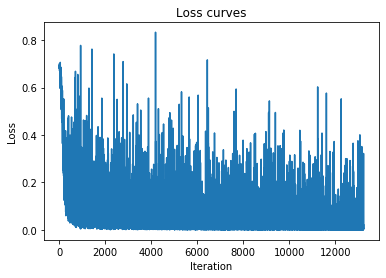

KeyboardInterrupt: 

In [13]:
for network in all_network:
    network.training()
    network.test()
    network.draw_plot()
    